# Equity Option Implied Volatility Analytics

We want to review the basics of Black-Scholes model and then estabilish a basic framework of vol surface calibration

## Input parameters to price options

Five input variables in Black-Scholes. four of which can be observed in the market and one of which is latent.

* Underlying Stock Price (S)
* Strike price (K)
* Time to expiration (t)
* Risk-free rate (r)
* Volatility (vol)

In [1]:
%matplotlib inline

# python standard libraries
import time
import datetime as dt
from math import sqrt, pi

# import numpy, pyplot and scipy
import numpy as np
import matplotlib as mat
mat.style.use('ggplot')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import pandas as pd
import yfinance as yf

print('Numpy %s\nMatplotlib %s\nScipy %s\nPandas %s' % \
      (np.__version__, mat.__version__, sp.__version__, pd.__version__))

# hypothetical market observables
S = 45
K = 45
t = 164 / 365
r = 0.02
vol = 0.25

# series of prices to demonstrate a payoff profile
S_ = np.arange(40, 50, 0.01)

Numpy 1.21.2
Matplotlib 3.4.3
Scipy 1.7.1
Pandas 1.3.4


Recall payoff function of options. These are option prices at expiration.

Call option
$$
C(S, K) = \max(S-K, 0)
$$

Put option
$$
P(S, K) = \max(K-S, 0)
$$

Black-Sholes gives us prices *before* expiration assuming no-arbitrage.

Text(0, 0.5, 'Payoff')

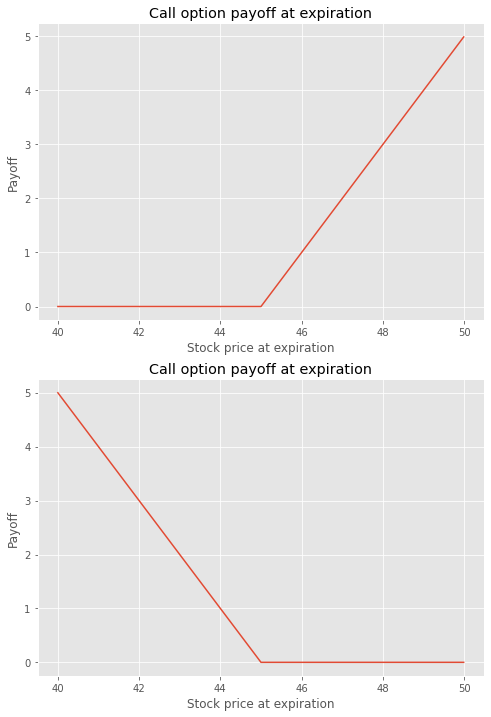

In [2]:
# define payoff functions
call_payoff = lambda S, K: np.maximum(S - K, 0)
put_payoff = lambda S, K: np.maximum(K - S, 0)

# plot payoff
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
# call option
axes[0].plot(S_, call_payoff(S_, K))
axes[0].set_title('Call option payoff at expiration')
axes[0].set_xlabel('Stock price at expiration')
axes[0].set_ylabel('Payoff')
# put option
axes[1].plot(S_, put_payoff(S_, K))
axes[1].set_title('Call option payoff at expiration')
axes[1].set_xlabel('Stock price at expiration')
axes[1].set_ylabel('Payoff')

## Review of Black-Scholes Model

Black-Scholes is largely understood as an option pricing formula but it is really a framework that models a financial market. Within the framework, it then derives option pricing formule using non-arbitrage principle and stochastic calculus.

The Black-Scholes model assumes the market consists of a risky asset (stock) and a risk-free asset (money market).

Assumptions on the market:
* The risk-free rate is constant
* The stock price follows geometric Brownian motion where drift and volatility are constant
* The stock does not pay dividends

Assumptions on the underlying securities
* No arbitrage opportunity
* Ability to borrow and lend any amount at risk-free rate
* Ability to buy or short sell any amount of the risky asset
* no transaction costs (frictionless marekt)
* The market is complete (we can replicate any payoff with the securities)

None of the assumptions are true in reality.

Under these assumptions, a derivative's price is completely determined at the current time, even though we do not know what the path the stock price will take in the future. For the special case of European call/put option, Black and Scholes showed that it is possible to create a hedged position, consisting of a long position in the stock and a short position in the option, whose value will not depend on the price of the stock. Their dynamic hedging strategy led to a partial differential equation which governed the price of the option. Its solution is given by Black-Scholes formula.

The Black-Scholes differential equation is:
$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
$$
where V is the value function of the derivative. The key financial insight behind the equation is that one can perfectly hedge the option by buying and selling the underlying asset in just the right way and consequently create an arbitrage-free environment. The hedge, in turn, implies that there is only one right price for the option, as returned by the Black-Scholes formula. For the dynamic hedgeing to work, one must continuously hedge the movement in the underlying stock price, which in reality is prohibitive due to transaction costs.

The solution from the PDQ for call option is
$$
C(S, t) = N(d_1)S - N(d_2)Ke^{-r(T-t)}
$$
and for put option is
$$
P(S, t) = N(-d_2)Ke^{-r(T-t)} - N(-d_1)S
$$
where
$$
\begin{aligned}
d_1 & = \frac{\ln(\frac{S}{K}) + (r + \frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}} \\
d_2 & = d_1 - \sigma\sqrt{T-t}
\end{aligned}
$$
and
* $N(\cdot)$ is the CDF of a standard normal distribution
* $T-t$ is the time to maturity (we use $t$ in the code)

In [3]:
# code the Black-Scholes formula

def N(z):
    # CDF of a standard normal distribution
    return norm.cdf(z)

def bsm_call_price(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    C = N(d1) * S - N(d2) * K * np.exp(-r * t)
    return C

def bsm_put_price(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    P = N(-d2) * K * np.exp(-r * t) - N(-d1) * S
    return P

In [4]:
print("Black-Scholes call value = {:.4f}".format(bsm_call_price(S, K, r, t, vol)))
print("Black-Scholes put value = {:.4f}".format(bsm_put_price(S, K, r, t, vol)))

Black-Scholes call value = 3.1970
Black-Scholes put value = 2.7945


Beause we vectorized the function, we can plot the Black-Scholes values along a range of underlying stock prices. We also compare different expirations. It shows us the time value of options.

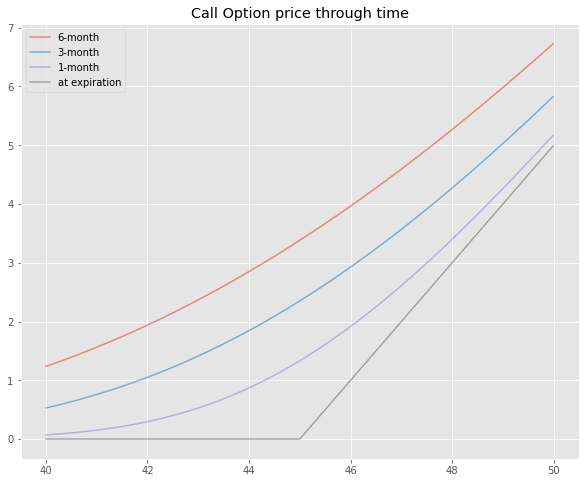

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(S_, bsm_call_price(S_, K, r, 0.5, vol), alpha=0.6, label="6-month")
ax.plot(S_, bsm_call_price(S_, K, r, 0.25, vol), alpha=0.6, label="3-month")
ax.plot(S_, bsm_call_price(S_, K, r, 1/12, vol), alpha=0.6, label="1-month")
ax.plot(S_, call_payoff(S_, K), alpha=0.6, label="at expiration")
ax.set_title("Call Option price through time")
ax.legend()
plt.show()

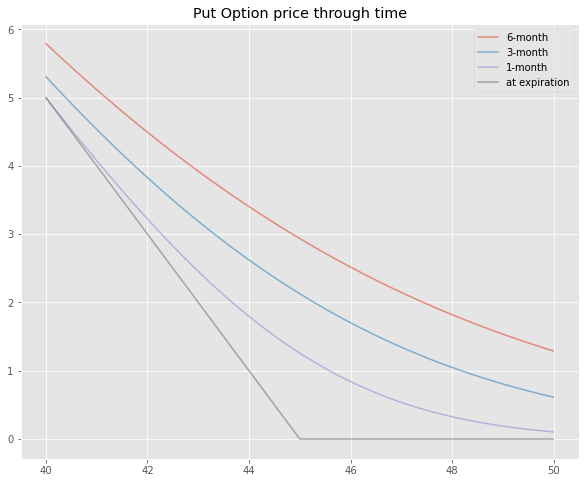

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(S_, bsm_put_price(S_, K, r, 0.5, vol), alpha=0.6, label="6-month")
ax.plot(S_, bsm_put_price(S_, K, r, 0.25, vol), alpha=0.6, label="3-month")
ax.plot(S_, bsm_put_price(S_, K, r, 1/12, vol), alpha=0.6, label="1-month")
ax.plot(S_, put_payoff(S_, K), alpha=0.6, label="at expiration")
ax.set_title("Put Option price through time")
ax.legend()
plt.show()

## The Greeks

The Greeks are the option price sensitivities to market variables. In mathematical terms, thay are partial derivatives.

Because the assumptions required for the Black-Scholes model do not hold true in practice, the plain vanilla formula is not usually used for pricing options for the purpose of trading. It is however, largely used for understanding the Greeks. The most common Greeks are as follows.

* **Delta**: sensitivity to underlying stock price (S)
$$
\begin{aligned}
\frac{\partial C}{\partial S} & = N(d_1) \\
\frac{\partial P}{\partial S} & = N(d_1) - 1
\end{aligned}
$$
* **Gamma**: sensitivity to the sensitivity to underlying stock price (S), i.e. second partial derivative
$$
\frac{\partial^2 C}{\partial S^2} = \frac{\partial^2 P}{\partial S^2} = \frac{\phi(d_1)}{S\sigma\sqrt{T-t}}
$$
* **Vega**: sensitivity to volatility (vol)
$$
\frac{\partial C}{\partial \sigma} = \frac{\partial P}{\partial \sigma} = S\phi(d_1)\sqrt{T-t}
$$
* **Theta**: sensitivity to time (t)
$$
\begin{aligned}
\frac{\partial C}{\partial t} &= -\frac{S\phi(d_1)\sigma}{2\sqrt{T-t}} - rKe^{-r(T-t)}N(d_2) \\
\frac{\partial P}{\partial t} &= -\frac{S\phi(d_1)\sigma}{2\sqrt{T-t}} + rKe^{-r(T-t)}N(-d_2)
\end{aligned}
$$
* **Rho**: sensitivity to risk-free rate (r)
$$
\begin{aligned}
\frac{\partial C}{\partial r} &= K(T-t)e^{-r(T-t)}N(d_2)\\
\frac{\partial P}{\partial r} &= -K(T-t)e^{-r(T-t)}N(-d_2)
\end{aligned}
$$

In [7]:
# code up the Greeks
def phi(x):
    return np.exp(x**2 / 2) / sqrt(2 * pi)

def bsm_call_delta(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    return N(d1)

def bsm_put_delta(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    return N(d1) - 1

def bsm_gamma(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    return phi(d1) / (S * vol * sqrt(t))

def bsm_vega(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    return (S * phi(d1) * sqrt(t)) / 100

def bsm_call_theta(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    theta = -((S * phi(d1) * vol) / (2 * np.sqrt(t))) - (r * K * np.exp(-r * t) * N(d2))
    return theta / 365

def bsm_put_theta(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    theta = -((S * phi(d1) * vol) / (2 * np.sqrt(t))) + (r * K * np.exp(-r * t) * N(d2))
    return theta / 365

def bsm_call_rho(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100

def bsm_put_rho(S, K, r, t, vol):
    d1 = (np.log(S/K) + (r + vol**2 / 2) * t) / (vol * np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100

In [8]:
# print the greek results
print("Black-Scholes call delta = %0.4f" % bsm_call_delta(S, K, r, t, vol))
print("Black-Scholes put delta = %0.4f" % bsm_put_delta(S, K, r, t, vol))
print("Black-Scholes gamma = %0.4f" % bsm_gamma(S, K, r, t, vol))
print("Black-Scholes vega = %0.4f" % bsm_vega(S, K, r, t, vol))
print("Black-Scholes call theta = %0.4f" % bsm_call_theta(S, K, r, t, vol))
print("Black-Scholes put theta = %0.4f" % bsm_put_theta(S, K, r, t, vol))
print("Black-Scholes call rho = %0.4f" % bsm_call_rho(S, K, r, t, vol))
print("Black-Scholes put rho = %0.4f" % bsm_put_rho(S, K, r, t, vol))

Black-Scholes call delta = 0.5546
Black-Scholes put delta = -0.4454
Black-Scholes gamma = 0.0534
Black-Scholes vega = 0.1215
Black-Scholes call theta = -0.0105
Black-Scholes put theta = -0.0081
Black-Scholes call rho = 0.0978
Black-Scholes put rho = -0.1026


## Implied Volatility

The Black-Scholes pricing formula is usually used to solve for implied volatility. Simply put, this means setting the Black-Scholes pricing formula equal to the market observed price and using a root-finding algorithm to solve for the volatility parameter.

The implied volatility is generally used for making trading decisions, calibrate other more exotic securities and researching market anomolies. For example, many traders use the so called volatility skewto understand the relative value of an option to other options trading in the market.

We first create an objective function, which then we'll pass to the Scipy implementation of the Brentq algorithm for root-finding.

In [9]:
def call_implied_volatility_objective_function(S, K, r, t, vol, call_option_market_price):
    return call_option_market_price - bsm_call_price(S, K, r, t, vol)

def call_implied_volatility(S, K, r, t, call_option_market_price, a=-2, b=2, xtol=1e-6):
    # avoid overlap with outer scope
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price
    
    def fcn(vol):
        return call_implied_volatility_objective_function(_S, _K, _r, _t, vol, _call_option_market_price)
    
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)   
        return np.nan if result <= xtol else result
    except ValueError:
        return np.nan

def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    return put_option_market_price - bsm_put_price(S, K, r, t, vol)

def put_implied_volatility(S, K, r, t, put_option_market_price, a=-2, b=2, xtol=1e-6):
    # avoid overlap with outer scope
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price
    
    def fcn(vol):
        return put_implied_volatility_objective_function(_S, _K, _r, _t, vol, _put_option_market_price)
    
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)   
        return np.nan if result <= xtol else result
    except ValueError:
        return np.nan

In [10]:
# unit test
call_model_price = bsm_call_price(S, K, r, t, vol)
call_model_price_implied_vol = call_implied_volatility(S, K, r, t, call_model_price)

put_model_price = bsm_put_price(S, K, r, t, vol)
put_model_price_implied_vol = put_implied_volatility(S, K, r, t, put_model_price)

print(f"Original parameter vol = {vol:.4f}")
print(f"Call implied vol from model price = {call_model_price_implied_vol:.4f}")
print(f"Put implied vol from model price = {put_model_price_implied_vol:.4f}")

Original parameter vol = 0.2500
Call implied vol from model price = 0.2500
Put implied vol from model price = 0.2500


## Volatility Surface with options market data from Yahoo Finance

In [11]:
def get_options_data(asset: str) -> pd.DataFrame:
    # yahoo finance API
    ticker = yf.Ticker(asset)
    
    # lastest spot
    spot = ticker.history()['Close'][-1]
    
    dfs = []
    # loop over expiries
    for expiry_str in ticker.options:
        opt = ticker.option_chain(expiry_str)
        # call options
        calls = opt.calls.copy()
        calls['asset'] = asset
        calls['expiry'] = pd.to_datetime(expiry_str)
        calls['type'] = 'Call'
        calls['spot'] = spot
        del calls['percentChange']
        del calls['impliedVolatility']
        del calls['contractSymbol']
        dfs.append(calls)
        # put options
        puts = opt.puts.copy()
        puts['asset'] = asset
        puts['expiry'] = pd.to_datetime(expiry_str)
        puts['type'] = 'Put'
        puts['spot'] = spot
        del puts['percentChange']
        del puts['impliedVolatility']
        del puts['contractSymbol']
        dfs.append(puts)
    
    # combine all and rearrange columns
    all_options = pd.concat(dfs)
    all_options = all_options[['asset', 'spot', 'type', 'expiry', 'strike', 'lastTradeDate',
                               'lastPrice', 'bid', 'ask', 'volume',
                               'openInterest', 'inTheMoney', 'contractSize', 'currency']]
    return all_options

We use GOOG as our example because it doesn't pay dividends so that we don't need to worry about it

In [12]:
Asset = 'GOOG'
options_data = get_options_data(Asset)
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2993 entries, 0 to 82
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   asset          2993 non-null   object        
 1   spot           2993 non-null   float64       
 2   type           2993 non-null   object        
 3   expiry         2993 non-null   datetime64[ns]
 4   strike         2993 non-null   float64       
 5   lastTradeDate  2993 non-null   datetime64[ns]
 6   lastPrice      2993 non-null   float64       
 7   bid            2992 non-null   float64       
 8   ask            2993 non-null   float64       
 9   volume         2695 non-null   float64       
 10  openInterest   2991 non-null   float64       
 11  inTheMoney     2993 non-null   bool          
 12  contractSize   2993 non-null   object        
 13  currency       2993 non-null   object        
dtypes: bool(1), datetime64[ns](2), float64(7), object(4)
memory usage: 330.3+ 

In [13]:
# clean stale data
# only keep options that traded today
from datetime import datetime
options_frame = options_data[options_data['lastTradeDate'] > datetime.today().replace(hour=0, minute=0, second=0)].copy()
# the 'copy' here is important, otherwise we get SettingWithCopyWarning in further operations
options_frame

,asset,spot,type,expiry,strike,lastTradeDate,lastPrice,bid,ask,volume,openInterest,inTheMoney,contractSize,currency
18,GOOG,2934.959961,Call,2021-11-12,2490.0,2021-11-11 16:33:26,467.55,439.8,447.3,2.0,2.0,True,REGULAR,USD
19,GOOG,2934.959961,Call,2021-11-12,2500.0,2021-11-11 15:35:53,452.20,430.1,440.7,3.0,1.0,True,REGULAR,USD
22,GOOG,2934.959961,Call,2021-11-12,2550.0,2021-11-11 14:56:55,411.80,379.8,390.7,1.0,8.0,True,REGULAR,USD
25,GOOG,2934.959961,Call,2021-11-12,2600.0,2021-11-11 16:42:07,362.18,330.0,340.9,2.0,7.0,True,REGULAR,USD
31,GOOG,2934.959961,Call,2021-11-12,2650.0,2021-11-11 15:37:00,303.40,283.0,290.8,2.0,13.0,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,GOOG,2934.959961,Put,2023-06-16,2650.0,2021-11-11 18:05:02,260.50,255.5,273.5,2.0,15.0,False,REGULAR,USD
31,GOOG,2934.959961,Call,2024-01-19,2000.0,2021-11-11 20:06:17,1100.00,1083.5,1100.5,1.0,32.0,True,REGULAR,USD
53,GOOG,2934.959961,Call,2024-01-19,2830.0,2021-11-11 18:06:51,571.00,550.0,568.0,1.0,8.0,True,REGULAR,USD
75,GOOG,2934.959961,Call,2024-01-19,3300.0,2021-11-11 14:44:01,375.00,350.5,369.0,1.0,10.0,False,REGULAR,USD


In [14]:
options_frame.describe(include='all', datetime_is_numeric=True)

,asset,spot,type,expiry,strike,lastTradeDate,lastPrice,bid,ask,volume,openInterest,inTheMoney,contractSize,currency
count,665,665.000000,665,665,665.000000,665,665.000000,665.000000,665.000000,665.000000,665.000000,665,665,665
unique,1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
top,GOOG,NaN,Put,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,REGULAR,USD
freq,665,NaN,338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,477,665,665
mean,NaN,2934.959961,NaN,2022-01-07 21:26:15.338345984,2829.924812,2021-11-11 18:26:51.410526464,97.099744,93.543459,98.042256,29.987970,203.857143,NaN,NaN,NaN
min,NaN,2934.959961,NaN,2021-11-12 00:00:00,540.000000,2021-11-11 14:30:01,0.010000,0.000000,0.050000,1.000000,0.000000,NaN,NaN,NaN
25%,NaN,2934.959961,NaN,2021-11-19 00:00:00,2750.000000,2021-11-11 16:23:46,3.400000,3.000000,4.800000,2.000000,23.000000,NaN,NaN,NaN
50%,NaN,2934.959961,NaN,2021-11-26 00:00:00,2905.000000,2021-11-11 18:45:01,25.270000,23.300000,26.400000,5.000000,78.000000,NaN,NaN,NaN
75%,NaN,2934.959961,NaN,2021-12-23 00:00:00,3010.000000,2021-11-11 20:40:31,78.800000,76.200000,84.200000,20.000000,199.000000,NaN,NaN,NaN
max,NaN,2934.959961,NaN,2024-01-19 00:00:00,4300.000000,2021-11-11 20:59:58,2158.000000,2133.800000,2142.400000,602.000000,4434.000000,NaN,NaN,NaN


Let's define some helper functions. These will help provide some inputs to the implied volatility calculation.

In [15]:
from datetime import timedelta

def _get_days_until_expiration(row):
    expiration = row['expiry'] + timedelta(hours=23, minutes=59, seconds=59)
    today = datetime.today()
    # add one to count for today
    return (expiration - today).days + 1

def _get_day_count_fraction_until_expiration(row):
    expiration = row['expiry'] + timedelta(hours=23, minutes=59, seconds=59)
    dcf = (expiration - datetime.today()) / timedelta(365) # ignore leap years
    return dcf

def _get_rate_helper():
    # closure for the get rate function
    # approximate risk-free rates using an extremely simplified yield curve
    terms = np.array([30, 2*30, 3*30, 6*30, 12*30, 24*30, 36*30, 60*30, 72*30, 120*30, 240*30, 360*30])
    rates = np.array([0.06, 0.06, 0.05, 0.07,0.17, 0.51, 0.83, 1.23, 1.45, 1.56, 1.96, 1.92]) / 100
    # create a linear interpolate function
    f = interp1d(terms, rates, kind='linear')
    def rate(row):
        # assume days until expiration is already calculated
        days = row['daysUntilExpiration']
        return f(max(days, 30)).round(decimals=8)
    return rate

_get_rate = _get_rate_helper()

def _get_mid(row):
    bid = row['bid']
    ask = row['ask']
    last = row['lastPrice']
    
    # if bid or ask doesn't exist, return zero
    if np.isnan(ask) or np.isnan(bid):
        return 0
    # if bid or ask is zero, return the last traded price
    elif bid == 0 or ask == 0:
        return last
    else:
        return (bid + ask) / 2

In [16]:
options_frame['daysUntilExpiration'] = options_frame.apply(_get_days_until_expiration, axis=1)
options_frame['timeUntilExpiration'] = options_frame.apply(_get_day_count_fraction_until_expiration, axis=1)
options_frame['interestRate'] = options_frame.apply(_get_rate, axis=1)
options_frame['mid'] = options_frame.apply(_get_mid, axis=1)

In [17]:
options_frame

,asset,spot,type,expiry,strike,lastTradeDate,lastPrice,bid,ask,volume,openInterest,inTheMoney,contractSize,currency,daysUntilExpiration,timeUntilExpiration,interestRate,mid
18,GOOG,2934.959961,Call,2021-11-12,2490.0,2021-11-11 16:33:26,467.55,439.8,447.3,2.0,2.0,True,REGULAR,USD,2,0.003540,0.000600,443.55
19,GOOG,2934.959961,Call,2021-11-12,2500.0,2021-11-11 15:35:53,452.20,430.1,440.7,3.0,1.0,True,REGULAR,USD,2,0.003540,0.000600,435.40
22,GOOG,2934.959961,Call,2021-11-12,2550.0,2021-11-11 14:56:55,411.80,379.8,390.7,1.0,8.0,True,REGULAR,USD,2,0.003540,0.000600,385.25
25,GOOG,2934.959961,Call,2021-11-12,2600.0,2021-11-11 16:42:07,362.18,330.0,340.9,2.0,7.0,True,REGULAR,USD,2,0.003540,0.000600,335.45
31,GOOG,2934.959961,Call,2021-11-12,2650.0,2021-11-11 15:37:00,303.40,283.0,290.8,2.0,13.0,True,REGULAR,USD,2,0.003540,0.000600,286.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,GOOG,2934.959961,Put,2023-06-16,2650.0,2021-11-11 18:05:02,260.50,255.5,273.5,2.0,15.0,False,REGULAR,USD,583,1.595321,0.003806,264.50
31,GOOG,2934.959961,Call,2024-01-19,2000.0,2021-11-11 20:06:17,1100.00,1083.5,1100.5,1.0,32.0,True,REGULAR,USD,800,2.189841,0.005811,1092.00
53,GOOG,2934.959961,Call,2024-01-19,2830.0,2021-11-11 18:06:51,571.00,550.0,568.0,1.0,8.0,True,REGULAR,USD,800,2.189841,0.005811,559.00
75,GOOG,2934.959961,Call,2024-01-19,3300.0,2021-11-11 14:44:01,375.00,350.5,369.0,1.0,10.0,False,REGULAR,USD,800,2.189841,0.005811,359.75


We now have all the imput parameters we need to calcualte implied volatility on each option

In [18]:
def _get_implied_vol_mid(row):
    option_type = row['type']
    S = row['spot']
    K = row['strike']
    r = row['interestRate']
    t = row['timeUntilExpiration']
    mid = row['mid']
    
    if option_type == 'Call':
        return call_implied_volatility(S, K, r, t, mid)
    else:
        return put_implied_volatility(S, K, r, t, mid)

In [19]:
options_frame['ImpliedVolatilityMid'] = options_frame.apply(_get_implied_vol_mid, axis=1)
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665 entries, 18 to 79
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   asset                 665 non-null    object        
 1   spot                  665 non-null    float64       
 2   type                  665 non-null    object        
 3   expiry                665 non-null    datetime64[ns]
 4   strike                665 non-null    float64       
 5   lastTradeDate         665 non-null    datetime64[ns]
 6   lastPrice             665 non-null    float64       
 7   bid                   665 non-null    float64       
 8   ask                   665 non-null    float64       
 9   volume                665 non-null    float64       
 10  openInterest          665 non-null    float64       
 11  inTheMoney            665 non-null    bool          
 12  contractSize          665 non-null    object        
 13  currency            

### Interpolating missing and bad values

The implied volatility solver will blow up if the option's mid price leads to a negative implied volatility. This happens with deep in or out of money options where market makers keep the bid-ask spread wide. It may also happen when an option is soon to expire.

In [20]:
bad_iv = options_frame[np.isnan(options_frame['ImpliedVolatilityMid'])]

In [21]:
bad_iv.groupby(['strike']).count()['spot']

strike
1650.0    1
1690.0    1
2000.0    1
2180.0    1
2490.0    1
2560.0    1
2670.0    1
2680.0    1
2700.0    1
2710.0    1
2810.0    1
2815.0    1
2820.0    1
2840.0    1
2880.0    1
2995.0    1
3040.0    1
3250.0    1
3300.0    1
3350.0    1
3450.0    1
4200.0    1
Name: spot, dtype: int64

In [22]:
bad_iv.groupby(['expiry']).count()['strike']

expiry
2021-11-12    14
2021-11-19     8
Name: strike, dtype: int64

Now we will interpolate the missing implied volatility values. There are *much* more sophisticated ways of doing this but we will settle for a simple linear interpolation.

In [25]:
def _interp_implied_volatility(options_frame):
    # split the chains into expiration and type
    frame = options_frame.set_index(['expiry', 'type', 'strike']).sort_index()
    
    # pivot the frame with ImpliedVolatilityMid as the values in the table
    # this has Strikes along the rows and Expiries along the columns
    # the level=1 unstack pivots on expiry and level=0 unstack pivots on option type
    unstacked = frame['ImpliedVolatilityMid'].unstack(level=1).unstack(level=0)
    
    # this line does three things
    #   first interpolates across each expiry down the strikes for np.nan values
    #   second forward fills values which keeps the last interpolated values as the value to fill
    #   third back fills values which keeps the first interpolated value as the value to fill
    unstack_interp = unstacked.interpolate().ffill().bfill()
    
    # restack into shape of original DataFrame
    unstack_interp_indexed = unstack_interp.stack(level=0).stack(level=0).reset_index()
    
    # replace old column with new column with interpolated and filled values
    # this step magically does index-matching to the original frame
    frame['ImpliedVolatilityMid'] = unstack_interp_indexed.set_index(['expiry', 'type', 'strike'])
    
    frame.reset_index(inplace=True)
    return frame

In [26]:
options_frame = _interp_implied_volatility(options_frame)

In [27]:
# check to see if there are remaining np.nans
bad_iv_post = options_frame[np.isnan(options_frame['ImpliedVolatilityMid'])]
bad_iv_post.shape

(0, 19)

### Calculate greeks

In [28]:
def _get_param(row):
    return row['type'], row['spot'], row['strike'], row['interestRate'], row['timeUntilExpiration'], row['ImpliedVolatilityMid']

def _get_delta(row):
    option_type, S, K, r, t, vol = _get_param(row)
    
    if option_type == 'Call':
        return bsm_call_delta(S, K, r, t, vol)
    else:
        return bsm_put_delta(S, K, r, t, vol)
    
def _get_gamma(row):
    option_type, S, K, r, t, vol = _get_param(row)
    
    return bsm_gamma(S, K, r, t, vol)
    
def _get_vega(row):
    option_type, S, K, r, t, vol = _get_param(row)
    
    return bsm_vega(S, K, r, t, vol)
    
def _get_theta(row):
    option_type, S, K, r, t, vol = _get_param(row)
    
    if option_type == 'Call':
        return bsm_call_theta(S, K, r, t, vol)
    else:
        return bsm_put_theta(S, K, r, t, vol)
    
def _get_rho(row):
    option_type, S, K, r, t, vol = _get_param(row)
    
    if option_type == 'Call':
        return bsm_call_rho(S, K, r, t, vol)
    else:
        return bsm_put_rho(S, K, r, t, vol)

def _get_option_value(row):
    option_type, S, K, r, t, vol = _get_param(row)
    
    if option_type == 'Call':
        return bsm_call_price(S, K, r, t, vol)
    else:
        return bsm_put_price(S, K, r, t, vol)

def _get_model_error(row):
    option_mid = row['mid']
    return option_mid - _get_option_value(row)

In [29]:
options_frame['Delta'] = options_frame.apply(_get_delta, axis=1)
options_frame['Gamma'] = options_frame.apply(_get_gamma, axis=1)
options_frame['Vega'] = options_frame.apply(_get_vega, axis=1)
options_frame['Theta'] = options_frame.apply(_get_theta, axis=1)
options_frame['Rho'] = options_frame.apply(_get_rho, axis=1)
options_frame['TheoreticalValue'] = options_frame.apply(_get_option_value, axis=1)
options_frame['ModelError'] = options_frame.apply(_get_model_error, axis=1)

In [30]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   expiry                665 non-null    datetime64[ns]
 1   type                  665 non-null    object        
 2   strike                665 non-null    float64       
 3   asset                 665 non-null    object        
 4   spot                  665 non-null    float64       
 5   lastTradeDate         665 non-null    datetime64[ns]
 6   lastPrice             665 non-null    float64       
 7   bid                   665 non-null    float64       
 8   ask                   665 non-null    float64       
 9   volume                665 non-null    float64       
 10  openInterest          665 non-null    float64       
 11  inTheMoney            665 non-null    bool          
 12  contractSize          665 non-null    object        
 13  currency            

In [31]:
options_frame.head()

,expiry,type,strike,asset,spot,lastTradeDate,lastPrice,bid,ask,volume,...,interestRate,mid,ImpliedVolatilityMid,Delta,Gamma,Vega,Theta,Rho,TheoreticalValue,ModelError
0,2021-11-12,Call,2490.0,GOOG,2934.959961,2021-11-11 16:33:26,467.55,439.8,447.3,2.0,...,0.0006,443.55,1.106717,0.994296,0.050657,17.093941,-732.139534,0.087533,445.325157,-1.775157e+00
1,2021-11-12,Call,2500.0,GOOG,2934.959961,2021-11-11 15:35:53,452.20,430.1,440.7,3.0,...,0.0006,435.40,1.106717,0.993226,0.043507,14.681348,-628.807909,0.087773,435.400000,9.400424e-09
2,2021-11-12,Call,2550.0,GOOG,2934.959961,2021-11-11 14:56:55,411.80,379.8,390.7,1.0,...,0.0006,385.25,0.936779,0.994623,0.063077,18.016715,-653.172796,0.089693,385.250000,-5.456968e-12
3,2021-11-12,Call,2600.0,GOOG,2934.959961,2021-11-11 16:42:07,362.18,330.0,340.9,2.0,...,0.0006,335.45,0.874888,0.990718,0.041720,11.129211,-376.820101,0.091050,335.450000,2.333679e-07
4,2021-11-12,Call,2650.0,GOOG,2934.959961,2021-11-11 15:37:00,303.40,283.0,290.8,2.0,...,0.0006,286.90,0.927857,0.969795,0.014356,4.061433,-145.842951,0.090595,286.900000,-6.798348e-08


## Analyzing Implied Volatility

### Volatility Skew

First we look at the implied volatility skew. This plots implied volatility for one expiration across strike prices. Given all else equal, an option with higher volatility will be more expensive. Generally deep in and out of the money strikes command higher pirces than the Black-Scholes model implies. This skew only began to appear after the 1987 crash. It may be explained by the "fat tails" of return distribution instead of normal.

In [32]:
options_frame['expiry'].unique()

array(['2021-11-12T00:00:00.000000000', '2021-11-19T00:00:00.000000000',
       '2021-11-26T00:00:00.000000000', '2021-12-03T00:00:00.000000000',
       '2021-12-10T00:00:00.000000000', '2021-12-17T00:00:00.000000000',
       '2021-12-23T00:00:00.000000000', '2022-01-21T00:00:00.000000000',
       '2022-02-18T00:00:00.000000000', '2022-03-18T00:00:00.000000000',
       '2022-06-17T00:00:00.000000000', '2023-01-20T00:00:00.000000000',
       '2023-06-16T00:00:00.000000000', '2024-01-19T00:00:00.000000000'],
      dtype='datetime64[ns]')

<AxesSubplot:title={'center':'Implied volatility skew'}, xlabel='strike'>

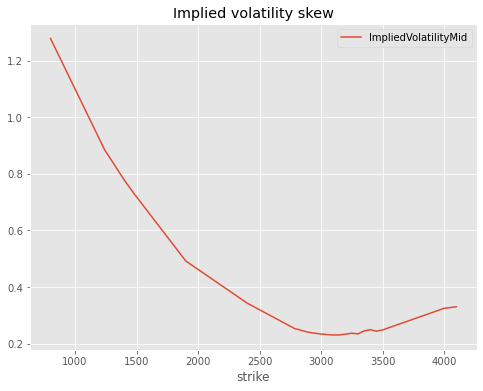

In [38]:
# select an expiration to plot
iv = options_frame[options_frame['expiry'] == '2022-01-21']
iv_call = iv[iv['type'] == 'Call']
iv_call[['strike', 'ImpliedVolatilityMid']].set_index('strike').plot(title="Implied volatility skew", figsize=(8, 6))

<AxesSubplot:xlabel='strike'>

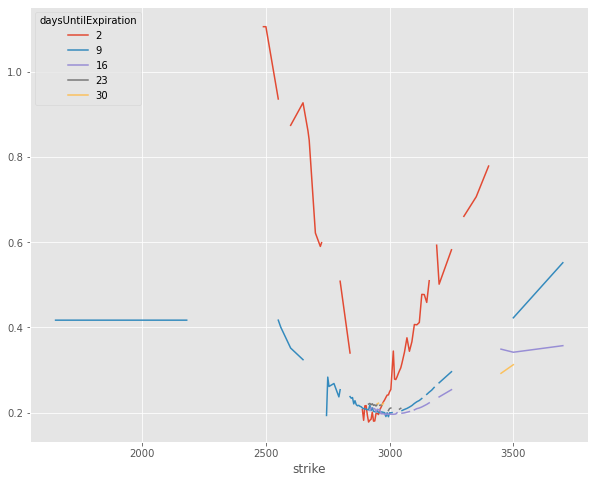

In [39]:
# multiple expirations
expirations = options_frame['expiry'].unique()[:5]
iv_multi_call = options_frame[(options_frame['type'] == 'Call') & (options_frame['expiry'].isin(expirations))]

iv_pivoted = iv_multi_call.pivot(index='strike', columns='daysUntilExpiration', values='ImpliedVolatilityMid')
iv_pivoted.plot(figsize=(10, 8))

### Term Structure of Volatility

<AxesSubplot:xlabel='expiry'>

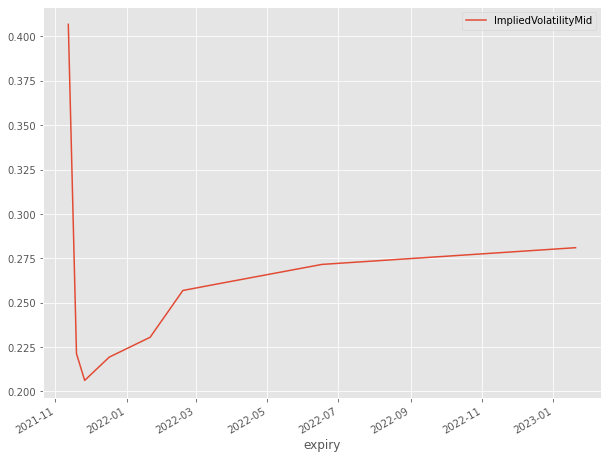

In [40]:
# select a strike to plot
iv = options_frame[(options_frame['strike'] == 3100) & (options_frame['type'] == 'Call')]
iv[['expiry', 'ImpliedVolatilityMid']].set_index('expiry').plot(figsize=(10, 8))

### Volatility Surface

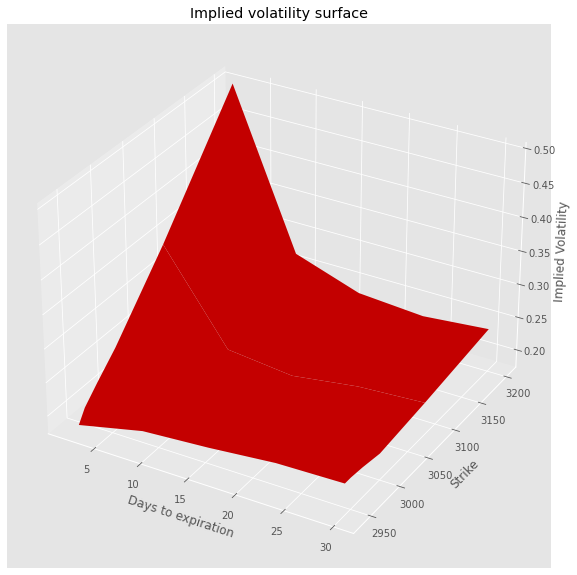

In [41]:
iv_multi_call = options_frame[(options_frame['type'] == 'Call') & (options_frame['expiry'].isin(expirations))]
iv_pivoted_surface = iv_multi_call[['daysUntilExpiration', 'strike', 'ImpliedVolatilityMid']].pivot(index='strike', columns='daysUntilExpiration', values='ImpliedVolatilityMid').dropna()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x, y, z = iv_pivoted_surface.columns.values, iv_pivoted_surface.index.values, iv_pivoted_surface.values
X, Y = np.meshgrid(x, y)

ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied volatility surface')

ax.plot_surface(X, Y, z, rstride=4, cstride=6, color='r')